# Medical image processing Homework : Hand Made model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import functional as TF

In [2]:
# Paths
train_img_dir = "/kaggle/input/datasettt/dataset/train_imgs"
train_label_dir = "/kaggle/input/datasettt/dataset/train_lbs"
test_img_dir = "/kaggle/input/datasettt/dataset/test_imgs"

## Dataset

In [3]:
# Define the dataset class

class CustomDataset(Dataset):

    def __init__(self, img_dir, label_dir=None, transform=None):

        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.label_dir:
            label_name = img_name.replace('.png', '.npy')
            label_path = os.path.join(self.label_dir, label_name)
            label = np.load(label_path)
            #label_resized = Image.fromarray(label).resize((256, 256), resample=Image.NEAREST)
            label_tensor = torch.from_numpy(np.array(label)).long()
        else:
            label_tensor = None

        if self.transform:
            image = self.transform(image)
            
        return image, label_tensor
        
def create_data_loaders(train_img_dir, train_label_dir, batch_size=32, validation_split=0.2):

    """
    Create DataLoaders for train, validation, and test sets.
    Parameters:
        train_img_dir (str): Directory containing the training images.
        train_label_dir (str): Directory containing the training labels.
        test_img_dir (str): Directory containing the test images.
        batch_size (int): Batch size for the DataLoader.
        validation_split (float): Proportion of the training data to use as validation.
    Returns:
        train_loader, val_loader, test_loader (DataLoader): DataLoaders for the train, validation, and test sets.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load dataset and split into train and validation indices

    full_dataset = CustomDataset(train_img_dir, train_label_dir, transform=transform)
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=validation_split, random_state=42)

    # Create subsets and corresponding DataLoaders

    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

    # Create DataLoaders

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader



train_loader, val_loader = create_data_loaders(train_img_dir=train_img_dir,
                                                            train_label_dir=train_label_dir,
                                                            batch_size=32,
                                                            validation_split=0.2)


print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of training samples:", len(train_loader.dataset))
print("Number of validation samples:", len(val_loader.dataset))

Number of training batches: 23
Number of validation batches: 6
Number of training samples: 713
Number of validation samples: 179


In [4]:
# Testing the training loader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

# Testing the validation loader
for images, labels in val_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 1, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 1, 224, 224]) torch.Size([32, 224, 224])


In [5]:
transform2 = transforms.Compose([
        transforms.ToTensor()
    ])


class test_dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform2
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, img_name  # Return both the image tensor and the filename

# Update the DataLoader instantiation
test_data2 = test_dataset(test_img_dir, transform=transform2)
test_loader2 = DataLoader(test_data2, batch_size=32, shuffle=False)

# Print to verify
print("Number of batches in Test:", len(test_loader2))
for images, filenames in test_loader2:
    print(f'Image batch shape: {images.shape}')
    print(f'Filenames: {filenames[:5]}')  # Print the first few filenames to confirm
    break


Number of batches in Test: 5
Image batch shape: torch.Size([32, 1, 224, 224])
Filenames: ('Case_00007_35.png', 'Case_00007_6.png', 'Case_00007_31.png', 'Case_00009_19.png', 'Case_00009_30.png')


## Model

In [6]:
# Basic convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.use_residual = (in_channels == out_channels)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        if self.use_residual:
            out = out + x  # Residual connection
        out = self.relu(out)
        return out

# Squeeze-and-Excitation block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Up-sampling block
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)  # Includes skip connection
        self.se = SEBlock(out_channels)  # Optional squeeze-and-excitation block
    
    def forward(self, x1, skip):
        x1 = self.up(x1)  # Upsample
        x = torch.cat([x1, skip], dim=1)  # Concatenate with attended skip connection
        x = self.conv(x)  # Convolution block
        x = self.se(x)  # Apply SE block
        return x

# Attention gate block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # Ensure gating signal has the same spatial dimensions as x
        if g.size()[2:] != x.size()[2:]:
            g = nn.functional.interpolate(g, size=x.size()[2:], mode='bilinear', align_corners=False)
        
        g1 = self.W_g(g)  # Process gating signal
        x1 = self.W_x(x)  # Process skip connection
        psi = self.relu(g1 + x1)  # Combine gating signal and skip connection
        psi = self.psi(psi)  # Generate attention weights
        return x * psi  # Refine the skip connection



# Full U-Net model with Attention and SE blocks
class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithAttention, self).__init__()
        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(512, 1024, dilation=2)

        # Attention gates for skip connections
        self.att4 = AttentionBlock(1024, 512, 256)
        self.att3 = AttentionBlock(512, 256, 128)
        self.att2 = AttentionBlock(256, 128, 64)
        self.att1 = AttentionBlock(128, 64, 32)

        # Decoder
        self.up4 = UpBlock(1024, 512, 512)
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding path
        x1 = self.enc1(x)  # First encoder block
        x2 = self.enc2(self.pool(x1))  # Second encoder block
        x3 = self.enc3(self.pool(x2))  # Third encoder block
        x4 = self.enc4(self.pool(x3))  # Fourth encoder block
        x_bottleneck = self.bottleneck(self.pool(x4))  # Bottleneck
    
        # Apply attention gates after each skip connection
        x4_att = self.att4(g=x_bottleneck, x=x4)  # Gating signal from bottleneck
        x3_att = self.att3(g=self.up4.up(x_bottleneck), x=x3)  # Gating signal from upsampled bottleneck
        x2_att = self.att2(g=self.up3.up(x4_att), x=x2)  # Gating signal from upsampled x4_att
        x1_att = self.att1(g=self.up2.up(x3_att), x=x1)  # Gating signal from upsampled x3_att
    
        # Decoding path
        x4 = self.up4(x_bottleneck, x4_att)  # Decode and use attention-refined x4
        x3 = self.up3(x4, x3_att)  # Decode and use attention-refined x3
        x2 = self.up2(x3, x2_att)  # Decode and use attention-refined x2
        x1 = self.up1(x2, x1_att)  # Decode and use attention-refined x1
    
        out = self.out_conv(x1)  # Final output layer
        return out


In [7]:
def compute_iou(preds, labels, num_classes):
    """
    Compute IoU for each class.
    Args:
        preds (torch.Tensor): Predicted labels (batch_size, H, W)
        labels (torch.Tensor): True labels (batch_size, H, W)
        num_classes (int): Number of classes
    Returns:
        iou_list (list): List of IoU for each class
    """
    iou_list = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        union = (pred_inds | target_inds).sum().float().item()

        if union == 0:
            iou = float('nan')  # Avoid division by zero
        else:
            iou = intersection / union
        iou_list.append(iou)
    return iou_list

def compute_dice(preds, labels, num_classes):
    """
    Compute Dice Coefficient for each class.
    Args:
        preds (torch.Tensor): Predicted labels (batch_size, H, W)
        labels (torch.Tensor): True labels (batch_size, H, W)
        num_classes (int): Number of classes
    Returns:
        dice_list (list): List of Dice Coefficient for each class
    """
    dice_list = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        pred_sum = pred_inds.sum().float().item()
        target_sum = target_inds.sum().float().item()

        if pred_sum + target_sum == 0:
            dice = float('nan')  # Avoid division by zero
        else:
            dice = (2 * intersection) / (pred_sum + target_sum)
        dice_list.append(dice)
    return dice_list


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

model = UNetWithAttention(in_channels=1, out_channels=5).to(device)

Using device: cuda


In [9]:
# Loss and optimizer
def dice_loss(pred, target, smooth=1e-6):
    # Apply softmax if multi-class, or sigmoid if binary
    pred = torch.softmax(pred, dim=1) if pred.shape[1] > 1 else torch.sigmoid(pred)

    # Convert target to one-hot encoding if necessary
    if pred.shape[1] > 1:  # Multi-class case
        target = nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    # Flatten tensors
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    # Compute Dice coefficient
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice


#criterion = dice_loss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, num_classes=5):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_dice': [], 'val_dice': []
    }
    
    for epoch in range(num_epochs):
        
        # Training Phase
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        model.train()
        running_train_loss = 0.0
        train_iou_scores = []
        train_dice_scores = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            # Compute predictions
            preds = torch.argmax(outputs, dim=1)

            # Compute metrics
            iou = compute_iou(preds, labels, num_classes)
            dice = compute_dice(preds, labels, num_classes)

            train_iou_scores.append(iou)
            train_dice_scores.append(dice)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        val_iou_scores = []
        val_dice_scores = []
        
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                
                # Forward pass
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()

                # Compute predictions
                val_preds = torch.argmax(val_outputs, dim=1)

                # Compute metrics
                val_iou = compute_iou(val_preds, val_labels, num_classes)
                val_dice = compute_dice(val_preds, val_labels, num_classes)

                val_iou_scores.append(val_iou)
                val_dice_scores.append(val_dice)

        # Calculate average losses
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)

        # Compute average metrics
        train_iou_scores_np = np.array(train_iou_scores)  # Shape: (num_batches, num_classes)
        train_dice_scores_np = np.array(train_dice_scores)
        val_iou_scores_np = np.array(val_iou_scores)
        val_dice_scores_np = np.array(val_dice_scores)

        # Compute mean IoU and Dice for each class
        epoch_train_iou = np.nanmean(train_iou_scores_np, axis=0)  # Shape: (num_classes,)
        epoch_train_dice = np.nanmean(train_dice_scores_np, axis=0)
        epoch_val_iou = np.nanmean(val_iou_scores_np, axis=0)
        epoch_val_dice = np.nanmean(val_dice_scores_np, axis=0)

        # Record losses and metrics
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_iou'].append(epoch_train_iou)
        history['val_iou'].append(epoch_val_iou)
        history['train_dice'].append(epoch_train_dice)
        history['val_dice'].append(epoch_val_dice)

        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        print(f'Train Mean IoU: {np.nanmean(epoch_train_iou):.4f}, Val Mean IoU: {np.nanmean(epoch_val_iou):.4f}')
        print(f'Train Mean Dice: {np.nanmean(epoch_train_dice):.4f}, Val Mean Dice: {np.nanmean(epoch_val_dice):.4f}')
    
    return history

# Train the model
history = train_model(model, train_loader, val_loader,criterion, optimizer, num_epochs=25)

# save model
print("saving model")
torch.save(model.state_dict(), 'model.pth')

Epoch [1/25]
Epoch [1/25], Train Loss: 1.2882, Validation Loss: 1.4228
Train Mean IoU: 0.2918, Val Mean IoU: 0.2051
Train Mean Dice: 0.3299, Val Mean Dice: 0.2555
Epoch [2/25]
Epoch [2/25], Train Loss: 0.8504, Validation Loss: 0.7844
Train Mean IoU: 0.3513, Val Mean IoU: 0.3387
Train Mean Dice: 0.3728, Val Mean Dice: 0.3651
Epoch [3/25]
Epoch [3/25], Train Loss: 0.4950, Validation Loss: 0.4333
Train Mean IoU: 0.3867, Val Mean IoU: 0.3149
Train Mean Dice: 0.4203, Val Mean Dice: 0.3540
Epoch [4/25]
Epoch [4/25], Train Loss: 0.2468, Validation Loss: 0.2960
Train Mean IoU: 0.4445, Val Mean IoU: 0.2847
Train Mean Dice: 0.4921, Val Mean Dice: 0.3452
Epoch [5/25]
Epoch [5/25], Train Loss: 0.1362, Validation Loss: 0.1297
Train Mean IoU: 0.4701, Val Mean IoU: 0.4908
Train Mean Dice: 0.5137, Val Mean Dice: 0.5304
Epoch [6/25]
Epoch [6/25], Train Loss: 0.0856, Validation Loss: 0.0849
Train Mean IoU: 0.4893, Val Mean IoU: 0.4812
Train Mean Dice: 0.5289, Val Mean Dice: 0.5227
Epoch [7/25]
Epoch [7/

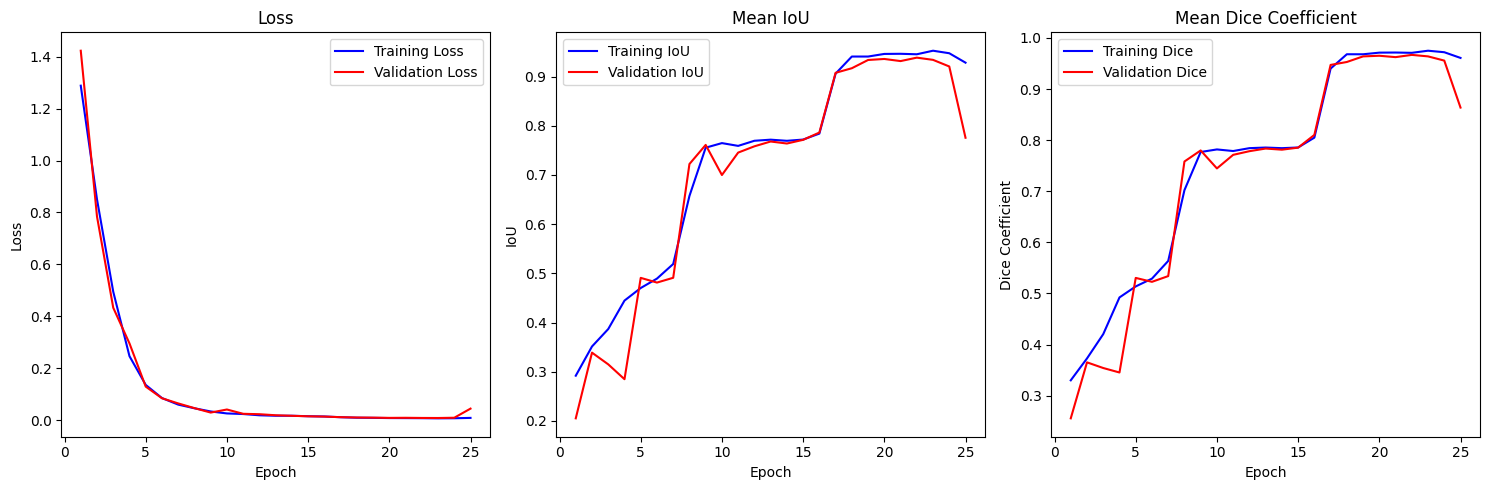

In [11]:
# Plot training history

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Mean IoU
    train_mean_iou = [np.nanmean(iou) for iou in history['train_iou']]
    val_mean_iou = [np.nanmean(iou) for iou in history['val_iou']]

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_mean_iou, 'b', label='Training IoU')
    plt.plot(epochs, val_mean_iou, 'r', label='Validation IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # Plot Mean Dice Coefficient
    train_mean_dice = [np.nanmean(dice) for dice in history['train_dice']]
    val_mean_dice = [np.nanmean(dice) for dice in history['val_dice']]

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_mean_dice, 'b', label='Training Dice')
    plt.plot(epochs, val_mean_dice, 'r', label='Validation Dice')
    plt.title('Mean Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the history
plot_history(history)


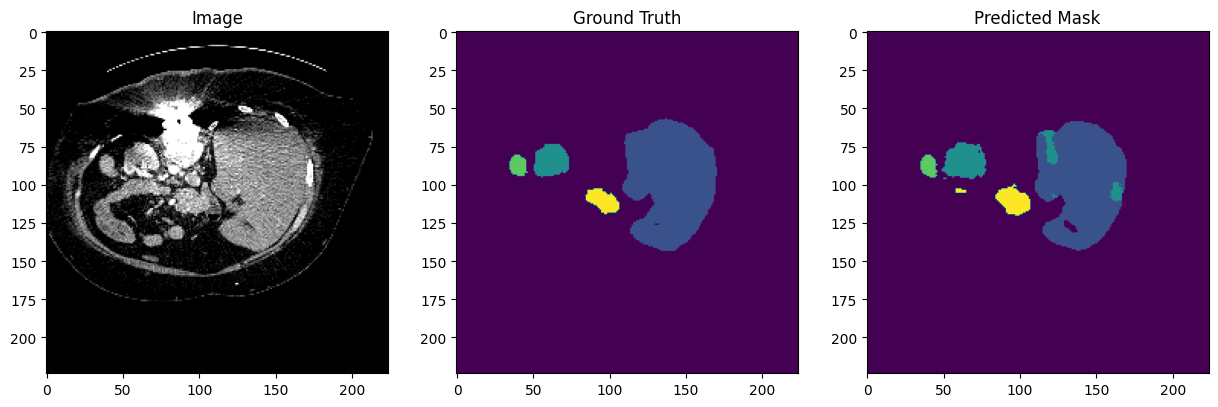

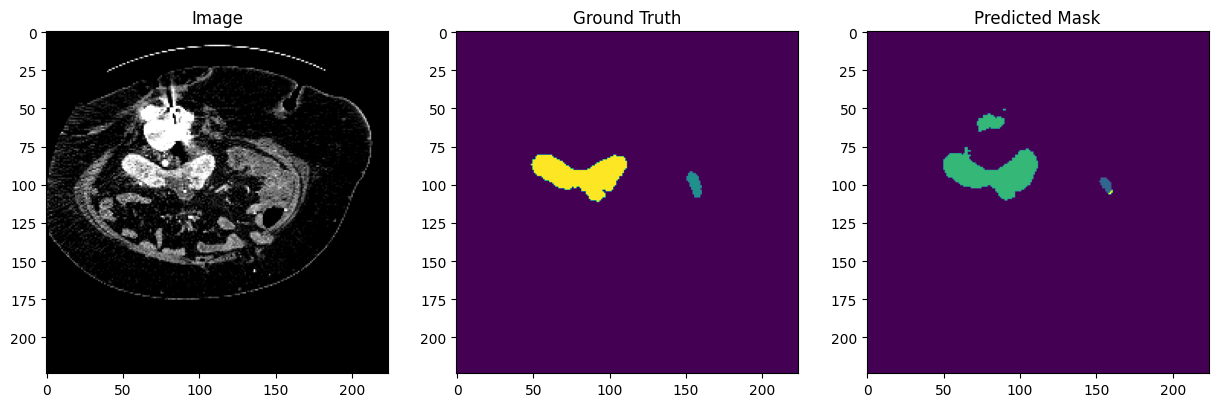

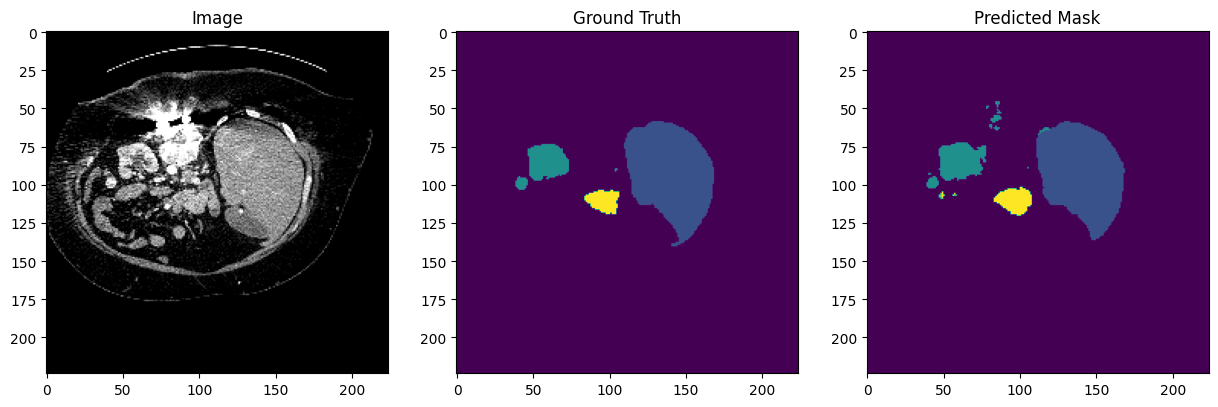

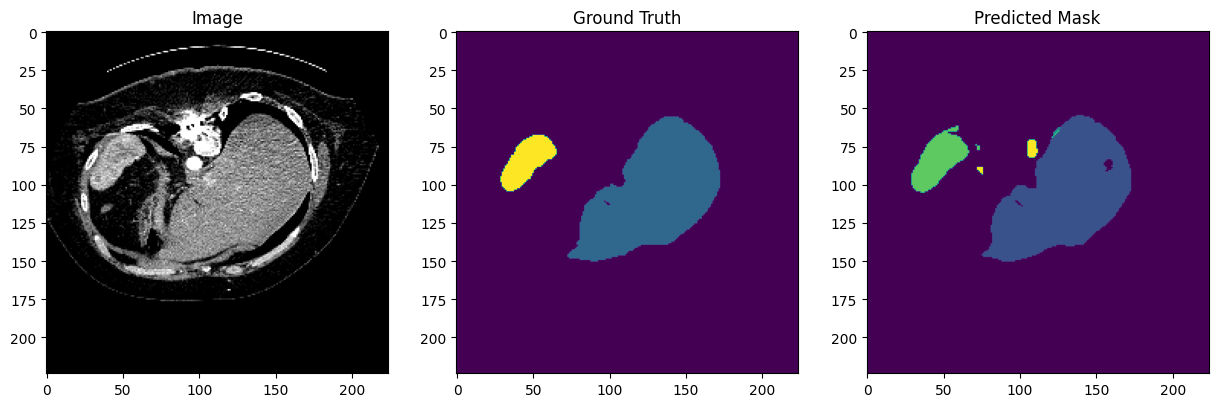

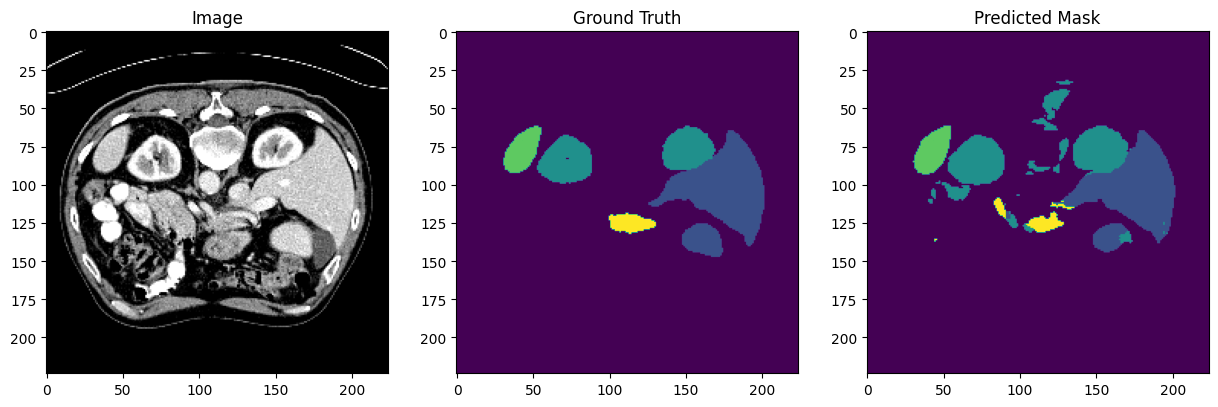

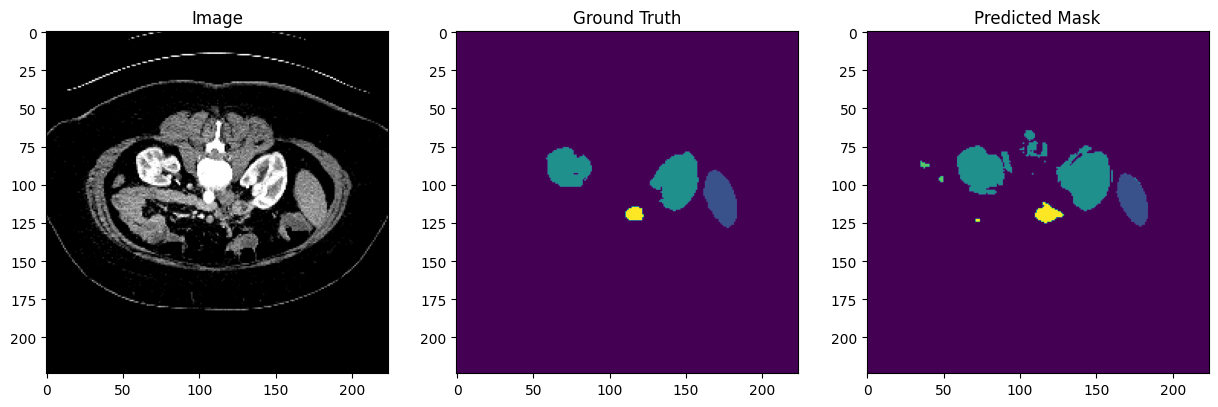

In [12]:
import matplotlib.pyplot as plt

# Initialize counter
i = 0

# Iterate through validation loader
for val_images, val_labels in val_loader:
    # Select the i-th image and label
    val_img = val_images[i]
    val_label = val_labels[i]

    # Prepare image for model
    val_img = val_img.unsqueeze(0).to(device)

    # Forward pass
    outputs = model(val_img)

    # Get predictions (argmax over classes)
    predictions = outputs.argmax(dim=1).squeeze(0).cpu().numpy()

    # Convert image and ground truth to numpy for visualization
    val_img_np = val_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    val_label_np = val_label.cpu().numpy()

    # Plot image, ground truth, and predictions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(val_img_np, cmap ='gray')
    axs[0].set_title('Image')
    axs[1].imshow(val_label_np)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(predictions)
    axs[2].set_title('Predicted Mask')
    plt.show()

    # Stop after visualizing 10 images
    i += 1
    if i == 20:
        break


## Model Evaluation

In [13]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from tqdm import tqdm

# Define classes for each organ in your dataset
classes = ["Liver", "Kidney", "Spleen", "Pancreas"]

# Store the results
results = {
    "Target": [],
    "F1-score": [],
    "Recall": [],
    "Precision": [],
    "Dice": [],
    "IoU": []
}

print("Loop")
for class_idx, class_name in enumerate(classes):

    y_true = []
    y_pred = []
    # Loop through the images and labels in your validation dataset
    for i, (image, label) in enumerate(tqdm(val_loader, desc=f"Processing {class_name}")):
        with torch.no_grad():  # Disable gradient calculations
            image = image.to(device)  # Move image to the same device as the model
            label = label.to(device)  # Move label to the same device as the model
            # Get the model predictions
            output = model(image)
            predictions = torch.argmax(output, dim=1)
            # Flatten arrays to compare each pixel
            y_true.extend((label == class_idx).cpu().numpy().flatten())
            y_pred.extend((predictions == class_idx).cpu().numpy().flatten())

        # Clear CUDA cache
        torch.cuda.empty_cache()

    # Convert y_true and y_pred to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics for the current class
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)

    # Dice coefficient is equivalent to F1-score for binary classification
    dice = f1

    # Calculate IoU
    iou = jaccard_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)

    # Append results to the table
    results["Target"].append(class_name)
    results["F1-score"].append(f1)
    results["Recall"].append(recall)
    results["Precision"].append(precision)
    results["Dice"].append(dice)
    results["IoU"].append(iou)
    
    # Delete lists to free up memory after each class calculation
    del y_true, y_pred

# Convert results to a DataFrame for easy display
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)

Loop


Processing Pancreas: 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


     Target  F1-score    Recall  Precision      Dice       IoU
0     Liver  0.993323  0.989100   0.997581  0.993323  0.986734
1    Kidney  0.970183  0.952343   0.988704  0.970183  0.942093
2    Spleen  0.775140  0.972583   0.644334  0.775140  0.632840
3  Pancreas  0.847181  0.994693   0.737771  0.847181  0.734878


## Saving Results

In [14]:
# Example of evaluation metric calculation (Dice score)
def dice_score(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    preds_one_hot = nn.functional.one_hot(preds, num_classes=num_classes).permute(0, 3, 1, 2)
    
    # Ensure both preds_one_hot and targets_one_hot have the same type and device
    preds_one_hot = preds_one_hot.type_as(targets)
    
    targets_one_hot = nn.functional.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)
    
    intersection = (preds_one_hot * targets_one_hot).sum(dim=(2, 3))
    union = preds_one_hot.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + 1.0) / (union + 1.0)
    return dice.mean().item()

# Compute dice score on test set
total_dice = 0.0
count = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        total_dice += dice_score(outputs, masks)
        count += 1

average_dice = total_dice / count
print(f'Average Dice Score on Val Set: {average_dice:.4f}')

Average Dice Score on Val Set: 0.7683


In [15]:
def rle_encode(mask):
    """Run-length encoding for a 2D mask."""
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Function to generate the CSV format for submission
def create_submission_csv(test_loader, model, device, output_csv_path='Unet_AttCrossEntropy.csv'):
    model.eval()
    submission_data = []
    with torch.no_grad():
        for i, (images, filenames) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1).cpu().numpy()  # Get predicted class masks

            # Generate Id and RLE for each image
            for idx, (filename, pred_mask) in enumerate(zip(filenames, predictions)):
                base_name = filename.split('.')[0]  # Extract the base name without extension
                for class_id in range(5):  # Classes: 0 (Background), 1 (Liver), 2 (Kidney), 3 (Spleen), 4 (Pancreas)
                    mask = (pred_mask == class_id).astype(np.uint8)
                    rle = rle_encode(mask) if mask.sum() > 0 else ''  # Encode to RLE if non-empty mask
                    submission_data.append([f"{base_name}_{class_id}", rle])

    # Create DataFrame and save to CSV
    submission_df = pd.DataFrame(submission_data, columns=['Id', 'Predicted'])
    submission_df.to_csv(output_csv_path, index=False)
    print(f"Submission CSV created at {output_csv_path}")

# Example usage
create_submission_csv(test_loader2, model, device)

Submission CSV created at Unet_AttCrossEntropy.csv
